In [1]:
%cd ~/Documents/hse/sberbank

/home/stasvlad/Documents/hse/sberbank


In [2]:
from utils import *

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

import lightgbm as lgb
from xgboost import XGBRegressor, DMatrix, cv
from xgboost import train as train_xgb

## Data description

In [3]:
macro_df = pd.read_csv('data/macro.csv', parse_dates=['timestamp'])
train_df = pd.read_csv('data/train.csv', index_col='id', parse_dates=['timestamp'])
test_df = pd.read_csv('data/test.csv', index_col='id', parse_dates=['timestamp'])
tverskoe_issue_fix(train_df)
tverskoe_issue_fix(test_df)

Fix:  550
Fix:  149


In [4]:
from IPython.display import set_matplotlib_formats
# STYLE
plt.style.use('seaborn-ticks')
# SVG
set_matplotlib_formats('svg')

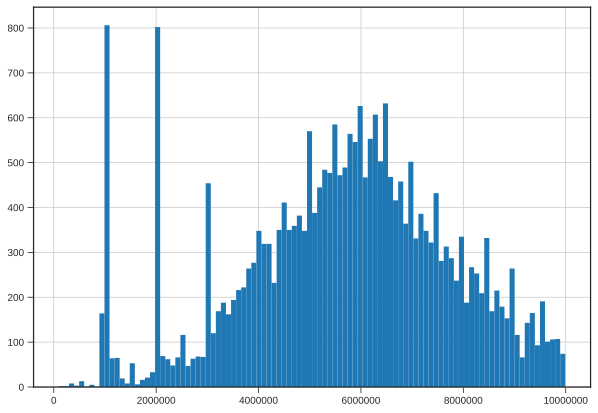

In [7]:
plt.figure(figsize=(10, 7))
train_df.loc[train_df['price_doc'] < 10000000, 'price_doc'].hist(bins=100);
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)

## 1. Data preprocessing
## I part (encoding and correcting mistakes)

### Macro dataset

In [3]:
macro_df['child_on_acc_pre_school'] = macro_df['child_on_acc_pre_school'].str.replace('#!', 'nan')
for column in macro_df.select_dtypes('object').columns:
    macro_df[column] = macro_df[column].str.replace(',', '.')
    macro_df[column] = macro_df[column].astype(float)

if not len(macro_df.select_dtypes('object').columns):
    print('OK')

OK


### Train dataset

In [4]:
train_df = encode(train_df)

### Test dataset

In [5]:
test_df = encode(test_df)

## II part (Filling missing values)

XGBRegressor model handles `np.NaN` values itself

## 2. Encoding `sub_area` feature

In [6]:
train_df['is_train'] = 1
test_df['is_train'] = 0

coords_df = pd.read_csv('data/coords.csv', index_col='id')
all_df = pd.concat([train_df, test_df])

all_df['latitude'] = coords_df['latitude']
all_df['longitude'] = coords_df['longitude']

## 3. Removing outliers

In [7]:
def remove_outliers(all_df):
    # Numerical outliers
    all_df.loc[all_df['full_sq'] < 10, 'full_sq'] = np.nan
    all_df.loc[all_df['full_sq'] > 1000, 'full_sq'] /= 100  # np.nan or /= 100

    all_df.loc[(all_df["full_sq"] > 250) &
               (all_df["life_sq"] / all_df["full_sq"] < 0.3), 'full_sq'] /= 10  # np.nan or /= 10

    all_df.loc[(all_df["full_sq"] > 210) &
               (all_df["price_doc"] < 10_000_000) &
               (all_df["life_sq"] > 100), 'life_sq'] /= 10  # np.nan or /= 10
    all_df.loc[(all_df["full_sq"] > 210) & (all_df["price_doc"] < 10_000_000), 'full_sq'] /= 10  # np.nan or /= 10

    all_df.loc[all_df['life_sq'] < 5, 'life_sq'] = np.nan
    all_df.loc[all_df['life_sq'] > 1000, 'life_sq'] /= 100  # 74/78 or /= 100
    all_df.loc[(all_df['life_sq'] > 300) &
               (all_df['life_sq'] == all_df['full_sq']*10), 'life_sq'] /= 10
    all_df.loc[all_df['life_sq'] > 300, 'life_sq'] /= 10  # np.nan or /= 10

    all_df.loc[13120, "build_year"] = all_df.loc[13120, "kitch_sq"]
    all_df.loc[all_df['kitch_sq'] > 200, 'kitch_sq'] = np.nan
    all_df.loc[all_df['kitch_sq'] < 2, 'kitch_sq'] = np.nan

    all_df.loc[all_df['floor'] == 0, 'floor'] = np.nan
    all_df.loc[all_df['floor'] == 77, 'floor'] = np.nan

    all_df.loc[all_df['max_floor'] == 0, 'max_floor'] = np.nan
    all_df.loc[all_df['max_floor'] > 57, 'max_floor'] = np.nan

    all_df.loc[all_df['build_year'] == 2, 'build_year'] = 2014
    all_df.loc[all_df['build_year'] == 20, 'build_year'] = 2014
    all_df.loc[all_df['build_year'] == 215, 'build_year'] = 2015
    all_df.loc[all_df['build_year'] == 1691, 'build_year'] = 1961
    all_df.loc[all_df['build_year'] == 4965, 'build_year'] = 1965
    all_df.loc[all_df['build_year'] == 20052009, 'build_year'] = 2009
    all_df.loc[all_df['build_year'] < 1850, 'build_year'] = np.nan
    all_df.loc[all_df['build_year'] > 2020, 'build_year'] = np.nan

    all_df.loc[all_df['num_room'] == 0, 'num_room'] = np.nan
    all_df.loc[all_df['num_room'] > 15, 'num_room'] = np.nan

    all_df.loc[all_df['state'] > 30, 'state'] = np.nan

    all_df.loc[all_df['preschool_quota'] == 0, 'preschool_quota'] = np.nan

    # Logical outliers
    all_df.loc[all_df['life_sq'] > all_df['full_sq'], 'life_sq'] = np.nan
    all_df.loc[all_df['floor'] > all_df['max_floor'], 'max_floor'] = np.nan
    all_df.loc[all_df['kitch_sq'] >= all_df['life_sq'], 'kitch_sq'] = np.nan

    return all_df

In [8]:
all_df = remove_outliers(all_df)

## 4. Feature engineering

In [9]:
all_df = create_new_features(all_df)

In [11]:
train_df = all_df[all_df['is_train'] == 1].drop(['is_train'], axis=1)
test_df = all_df[all_df['is_train'] == 0].drop(['is_train', 'price_doc'], axis=1)

## 5. Removing fake prices

In [10]:
train_df = remove_fake_prices(train_df)

REMOVED: 69
